This notebook is for fine-tuning a DeBERTa-v3-small model. It's reproducible if the PATHS class is set up correctly.

In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Download Data

In [ ]:
!kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification
!yes | unzip jigsaw-unintended-bias-in-toxicity-classification.zip
!rm jigsaw-unintended-bias-in-toxicity-classification.zip

In [ ]:
!pip install datasets
!pip install scikit-multilearn

# Set up

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'
import warnings
import numpy as np, pandas as pd
import random
import torch
from skmultilearn.model_selection import iterative_train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
warnings.simplefilter('ignore')

In [7]:
class PATHS:
    save = '/content/drive/MyDrive'
    fs = f'{save}/few_shot_labeled.tsv'
    sw = f'{save}/sw_labeled.tsv'
    ar = f'{save}/ar_labeled.tsv'
    arc = f'{save}/arc_labeled.tsv'
    toxic = f'{save}/toxic_labeled.tsv'
    ab = f'{save}/ab_labeled.tsv'
    toxic_train = 'train.csv'
    final_train = f'{save}/harm_train.tsv'
    final_test = f'{save}/harm_test.tsv'
    save_model_prep = f'{save}/harm-deberta-v3-small_prep'
    save_model = f'{save}/harm-deberta-v3-small'

In [8]:
class CFG:
    model_name = 'microsoft/deberta-v3-small'
    seed = 42
    max_length = 512
    lr = 1e-5
    train_batch_size = 32
    train_epochs = 4
    weight_decay = 0.01
    warmup_ratio = 0.0
    labels = ['self_harm', 'harming_others', 'harmed_by_others','reference_to_harm']

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(42)

# Load Data

The positive data set consists of data sets with positive data for labels 'self_harm', 'harming_others', 'harmed_by_others', or 'reference_to_harm'. They consists of few shot dataset, suicide watch dataset, abusive relationship dataset, abusive relationship comments dataset, toxic dataset, and all beauty dataset.

In [10]:
fs_df = pd.read_csv(PATHS.fs, sep='\t', dtype={'id': 'string'})
sw_df = pd.read_csv(PATHS.sw, sep='\t', dtype={'id': 'string'})
ar_df = pd.read_csv(PATHS.ar, sep='\t', dtype={'id': 'string'})
arc_df = pd.read_csv(PATHS.arc, sep='\t', dtype={'id': 'string'})
toxic_df = pd.read_csv(PATHS.toxic, sep='\t', dtype={'id': 'string'})
ab_df = pd.read_csv(PATHS.ab, sep='\t', dtype={'id': 'string'})
pos_dfs = [fs_df, sw_df, ar_df, arc_df, toxic_df, ab_df]
pos_names = ['few shot dataset', 'suicide watch dataset', 'abusive relationship dataset', 'abusive relationship comments dataset', 'toxic dataset', 'all beauty dataset']
pos_df = pd.concat(pos_dfs)

In [11]:
for df, name in zip(pos_dfs, pos_names):
    print(f"Numer of samples in {name} = {len(df)}")

Numer of samples in few shot dataset = 64
Numer of samples in suicide watch dataset = 5561
Numer of samples in abusive relationship dataset = 9502
Numer of samples in abusive relationship comments dataset = 7495
Numer of samples in toxic dataset = 9226
Numer of samples in all beauty dataset = 5371


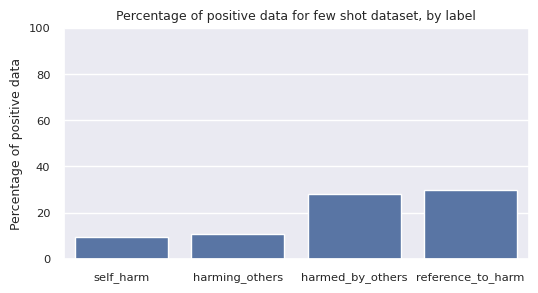

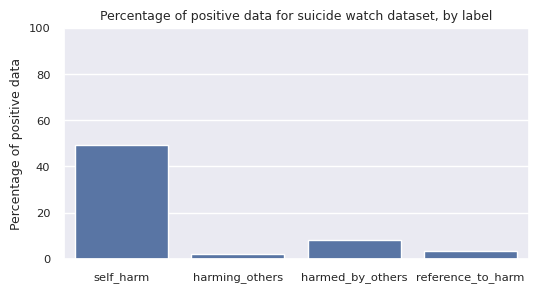

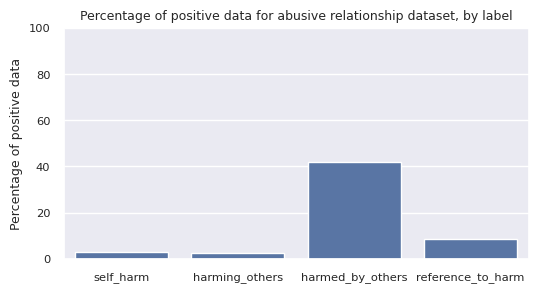

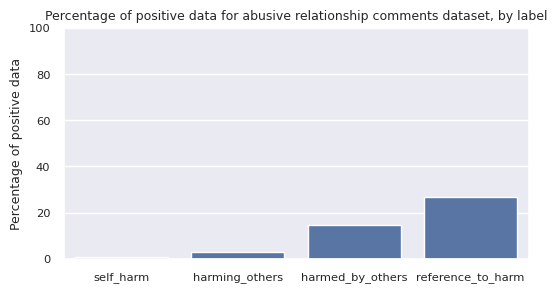

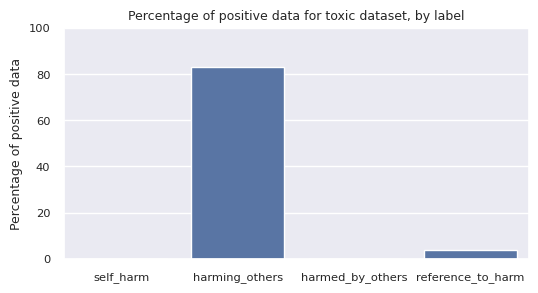

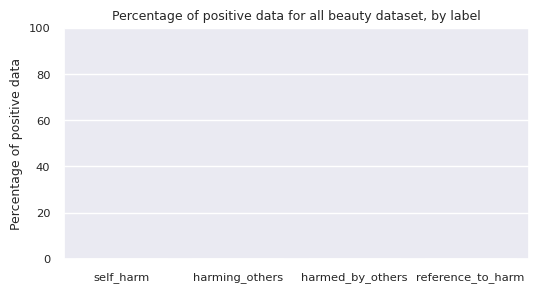

In [12]:
sns.set(font_scale=0.75)
for df, name in zip(pos_dfs, pos_names):
    plt.figure(figsize=(6, 3))
    plt.ylim(0, 100)
    plt.title(f"Percentage of positive data for {name}, by label")
    sns.barplot(x=CFG.labels, y=[sum(df[label] == 1)/len(df) * 100 for label in CFG.labels])
    plt.ylabel("Percentage of positive data")

In [13]:
print(f"Number of total no harm = {sum((pos_df['self_harm'] == 0) & (pos_df['harming_others'] == 0) & (pos_df['harmed_by_others'] == 0) & (pos_df['reference_to_harm'] == 0))}")
for label in CFG.labels:
    print(f"Number of total {label} = {sum(pos_df[label] == 1)}")

Number of total no harm = 17799
Number of total self_harm = 3125
Number of total harming_others = 8305
Number of total harmed_by_others = 5585
Number of total reference_to_harm = 3402


Text(0, 0.5, 'Percentage of positive data')

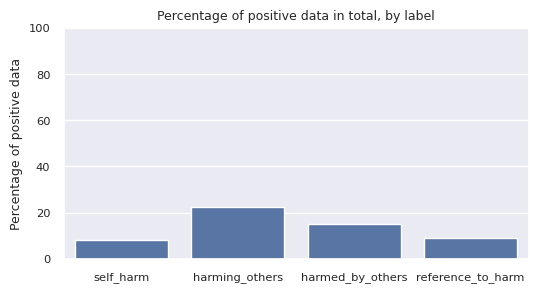

In [14]:
sns.set(font_scale=0.75)
plt.figure(figsize=(6, 3))
plt.ylim(0, 100)
plt.title(f"Percentage of positive data in total, by label")
sns.barplot(x=CFG.labels, y=[sum(pos_df[label] == 1)/len(pos_df) * 100 for label in CFG.labels])
plt.ylabel("Percentage of positive data")

The negative data set consists of data with 0 'toxicity' from the toxic data set. Even though I'd like to label them 0 in all harm labels, some of them have positive 'harmed_by_others' or 'reference_to_harm'. I go through a "prep training" process to filter them out.

In [15]:
toxic_train_df = pd.read_csv(PATHS.toxic_train, dtype={'id': 'string'})

In [16]:
neg_df = toxic_train_df.loc[toxic_train_df['target'] == 0].dropna()
neg_df = neg_df.rename(columns={'comment_text': 'text'})[['id', 'text']]
neg_df['text'] = neg_df['text'].str.replace('\n', ' ')
neg_df[CFG.labels] = [0, 0, 0, 0]

In [17]:
train_df = pd.concat([pos_df, neg_df])

# Train Test Split

In [18]:
X = train_df
y = train_df[CFG.labels]

In [19]:
X_train, y_train, X_test, y_test = iterative_train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.1)

In [20]:
train = pd.DataFrame(X_train, columns=(['id', 'text']+CFG.labels))
test = pd.DataFrame(X_test, columns=(['id', 'text']+CFG.labels))

# Tokenize Prep Train

pos_train are the part of the training split that belong to the original positive data set. In other words, they're what's left after I remove the 0 toxic data from the train split. I carry out a "prep training" based on this smaller set of training data.

In [21]:
pos_train = train[train['id'].isin(pos_df['id'])]

In [22]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

In [23]:
def tokenize_function(batch):
    tokenized_inputs = tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=CFG.max_length,
    )
    batch_labels = {label: batch[label] for label in CFG.labels}
    matrix_labels = np.zeros((len(batch['text']), len(CFG.labels)))
    for i, label in enumerate(CFG.labels):
        matrix_labels[:, i] = batch_labels[label]
    tokenized_inputs['labels'] = matrix_labels
    return tokenized_inputs

In [24]:
pos_train_dict = {}
for col in ['id', 'text'] + CFG.labels:
    pos_train_dict[col] = pos_train[col].tolist()

In [25]:
pos_train_ds = Dataset.from_dict(pos_train_dict)
tokenized_pos_train_ds = pos_train_ds.map(tokenize_function, batched=True)
tokenized_pos_train_ds.set_format('torch')

Map:   0%|          | 0/35275 [00:00<?, ? examples/s]

In [26]:
id2label = {i: label for i, label in enumerate(CFG.labels)}
label2id = {label: i for i, label in enumerate(CFG.labels)}

# Prep Training

In [27]:
config = AutoConfig.from_pretrained(CFG.model_name)
config.num_labels = len(CFG.labels)
config.problem_type = 'multi_label_classification'
config.id2label = id2label
config.label2id = label2id
model = AutoModelForSequenceClassification.from_pretrained(CFG.model_name, config=config)
model.resize_token_embeddings(len(tokenizer))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(128001, 768, padding_idx=0)

In [28]:
training_args = TrainingArguments(
    output_dir='output',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    save_strategy='epoch',
    save_total_limit=1,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear',
    optim='adamw_torch',
    logging_first_step=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_pos_train_ds,
    tokenizer=tokenizer,
)

In [29]:
trainer.train()

Step,Training Loss
1,0.680300
500,0.253500
1000,0.144400
1500,0.122400
2000,0.118000
2500,0.106600
3000,0.102300
3500,0.095900
4000,0.089400


TrainOutput(global_step=4412, training_loss=0.12554792207365995, metrics={'train_runtime': 4584.1304, 'train_samples_per_second': 30.78, 'train_steps_per_second': 0.962, 'total_flos': 1.86924824039424e+16, 'train_loss': 0.12554792207365995, 'epoch': 4.0})

In [30]:
trainer.save_model(PATHS.save_model_prep)

# Inference on the Negative Set (0 Toxic Data Set)




The negative data set (0 toxic data set) in fact contains some positive data in 'harmed_by_others' or 'reference_to_harm' labels. We run inference on them using the "prep training" model, and filter out the data that are positive in the harm labels.

In [31]:
sigmoid = torch.nn.Sigmoid()

In [32]:
neg_dict = {}
for col in ['id', 'text'] + CFG.labels:
    neg_dict[col] = neg_df[col].tolist()

In [33]:
neg_ds = Dataset.from_dict(neg_dict)
tokenized_neg_ds = neg_ds.map(tokenize_function, batched=True)
tokenized_neg_ds.set_format('torch')

Map:   0%|          | 0/144210 [00:00<?, ? examples/s]

In [34]:
neg_pred = trainer.predict(tokenized_neg_ds)

In [35]:
neg_proba = sigmoid(torch.Tensor(neg_pred.predictions)).numpy()
neg_pred = np.where(neg_proba >= 0.5, 1, 0)

In [36]:
neg_df[[label+'_pred' for label in CFG.labels]] = neg_pred
mask = ( (neg_df['self_harm'] != neg_df['self_harm_pred']) | (neg_df['harming_others'] != neg_df['harming_others_pred']) |
         (neg_df['harmed_by_others'] != neg_df['harmed_by_others_pred']) | (neg_df['reference_to_harm'] != neg_df['reference_to_harm_pred']) )

In [38]:
neg_drop_df = neg_df[mask]
train = train[~train['id'].isin(neg_drop_df['id'])]
test = test[~test['id'].isin(neg_drop_df['id'])]

Write filtered training and test

In [39]:
for label in CFG.labels:
    print(f"{label}: positives in training = {sum(train[label] == 1)}, positives in test = {sum(test[label] == 1)}")

self_harm: positives in training = 2813, positives in test = 312
harming_others: positives in training = 7475, positives in test = 830
harmed_by_others: positives in training = 5027, positives in test = 558
reference_to_harm: positives in training = 3062, positives in test = 340


In [40]:
train.to_csv(PATHS.final_train, sep='\t', index=False)
test.to_csv(PATHS.final_test, sep='\t', index=False)

In [41]:
print(len(train), len(test))

132485 14266


# Tokenize Train

Now we carry out the final tokenization and training on the filtered training set.

In [42]:
train = pd.read_csv(PATHS.final_train, sep='\t', dtype={'id': 'string'})

In [43]:
tokenizer = AutoTokenizer.from_pretrained(CFG.model_name)

In [44]:
def tokenize_function(batch):
    tokenized_inputs = tokenizer(
        batch['text'],
        padding=True,
        truncation=True,
        max_length=CFG.max_length,
    )
    batch_labels = {label: batch[label] for label in CFG.labels}
    matrix_labels = np.zeros((len(batch['text']), len(CFG.labels)))
    for i, label in enumerate(CFG.labels):
        matrix_labels[:, i] = batch_labels[label]
    tokenized_inputs['labels'] = matrix_labels
    return tokenized_inputs

In [45]:
train_dict = {}
for col in ['id', 'text'] + CFG.labels:
    train_dict[col] = train[col].tolist()

In [46]:
train_ds = Dataset.from_dict(train_dict)
tokenized_train_ds = train_ds.map(tokenize_function, batched=True)
tokenized_train_ds.set_format('torch')

Map:   0%|          | 0/132485 [00:00<?, ? examples/s]

In [47]:
id2label = {i: label for i, label in enumerate(CFG.labels)}
label2id = {label: i for i, label in enumerate(CFG.labels)}

# Training

In [48]:
config = AutoConfig.from_pretrained(CFG.model_name)
config.num_labels = len(CFG.labels)
config.problem_type = 'multi_label_classification'
config.id2label = id2label
config.label2id = label2id
model = AutoModelForSequenceClassification.from_pretrained(CFG.model_name, config=config)
model.resize_token_embeddings(len(tokenizer))

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(128001, 768, padding_idx=0)

In [49]:
training_args = TrainingArguments(
    output_dir='output',
    fp16=True,
    learning_rate=CFG.lr,
    per_device_train_batch_size=CFG.train_batch_size,
    num_train_epochs=CFG.train_epochs,
    weight_decay=CFG.weight_decay,
    save_strategy='epoch',
    save_total_limit=1,
    report_to='none',
    warmup_ratio=CFG.warmup_ratio,
    lr_scheduler_type='linear',
    optim='adamw_torch',
    logging_first_step=True,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_ds,
    tokenizer=tokenizer,
)

In [50]:
trainer.train()

Step,Training Loss
1,0.663700
500,0.147100
1000,0.064300
1500,0.052100
2000,0.045300
2500,0.043000
3000,0.039600
3500,0.037300
4000,0.036000
4500,0.033900


TrainOutput(global_step=16564, training_loss=0.032952358629990824, metrics={'train_runtime': 16939.9275, 'train_samples_per_second': 31.283, 'train_steps_per_second': 0.978, 'total_flos': 6.983164548956825e+16, 'train_loss': 0.032952358629990824, 'epoch': 4.0})

In [51]:
trainer.save_model(PATHS.save_model)